 Figure S9 

In [4]:
%pylab inline
import dbdreader
import cmocean as cm
import seawater as sw
import glidertools as gt
import gsw
import pandas as pd
import xarray as xr
import cmocean as cmo
import sys 
import os
import matplotlib.dates as md
import seaborn as sns
#Author of PrimaryProductionTools Isabelle Giddy available from doi: 
#https://github.com/isgiddy/roammiz-seaice-impacts-organic-carbon 
#doi.org/10.5281/zenodo.5655924
sys.path.append('/Users/sarahnicholson/Dropbox/PYTHON_CODE/PrimaryProductionTools/')
import PrimaryProductionTools as ppt

In [6]:
rcParams['savefig.dpi'] = 150
rcParams['figure.figsize'] = [6, 3]
rcParams['figure.dpi'] = 150
sns.set_style("white")
rcParams['font.size'] = 9
rcParams['font.family'] = 'Arial'
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
weeks = mdates.WeekdayLocator(interval=1)
days = mdates.DayLocator(interval=1)
hrs = mdates.HourLocator(interval=1)
daysFmt = mdates.DateFormatter("%h")
yearsFmt = mdates.DateFormatter("%d\%m")

# Load processed optics data

In [10]:
optics = xr.open_dataset('../Data/SOSCEx_STORM2_Glider_Data/slocum_optics_dates.nc')
par = pd.read_csv('../Data/SOSCEx_STORM2_Glider_Data/par_modis_collocated_glider.csv')
day_L =  pd.read_csv('../Data/SOSCEx_STORM2_Glider_Data/day_length.csv')

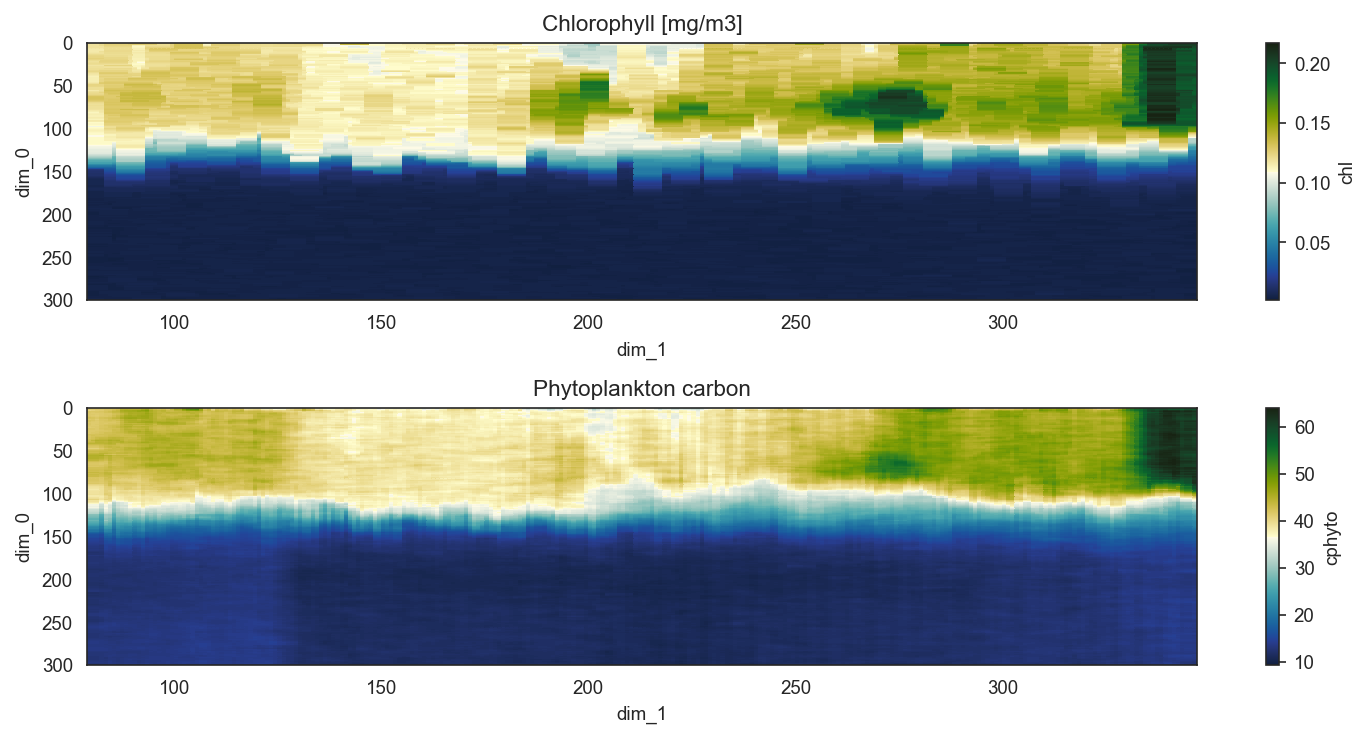

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(211)
optics.chl.plot(cmap=cmo.cm.delta);plt.ylim(300,0)
plt.title('Chlorophyll [mg/m3]')
plt.subplot(212)
optics.cphyto.plot(cmap=cmo.cm.delta);plt.ylim(300,0)
plt.title('Phytoplankton carbon')
plt.tight_layout()

# RUN PP model on glider data

In [5]:
# 1) iniatilise outputs
# depth, days
pp_z_sat643=np.ndarray([200,268])  # output Primary Production
mu_z_sat=np.ndarray([200,268])  # output  Phytoplankton growth rate
par_z_sat=np.ndarray([200,268]) # output Photosynthetically available radiation 
prcnt_z_sat=np.ndarray([200,268]) #output % remaining irradiance

In [16]:
for i in range(268):
    pp_z_sat643[:,i],mu_z_sat[:,i],par_z_sat[:,i],prcnt_z_sat[:,i]   = ppt.cbpm_bgcfloats(optics.chl[0:199,i].values,
                                                                            optics.cphyto[0:199,i].values,
                                                                            par.PAR.bfill().iloc[i],
                                                                            day_L.daylength.iloc[0])

# Integrate PP

In [36]:

pp_int = np.nansum(pp_z_sat643[0:200],0)
pp_int[pp_int==0] = np.nan


data= {'time': optics.time, 'ppint':pp_int}
tppz = pd.DataFrame(data)
tppz.set_index('time')

,ppint
time,
2018-12-19 00:00:01,453.307022
2018-12-19 00:00:01,446.794648
2018-12-19 00:00:01,446.821494
2018-12-19 00:00:01,453.854184
2018-12-19 00:00:01,461.232417
...,...
2019-02-07 00:50:01,738.865680
2019-02-08 00:25:01,396.231188
2019-02-08 00:25:01,395.810548


# COMPARE TO SATELITTE

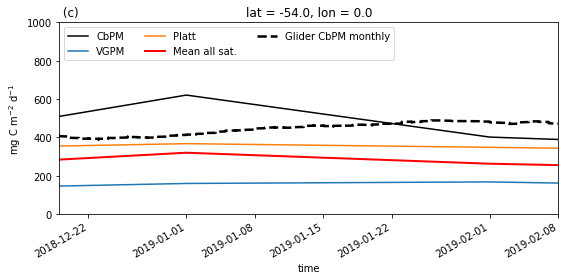

In [48]:
# compare to PP satelitte on monthly means:
#-------------------------------------------

fname='../Data/SOSCEx_STORM2_Glider_Data/PP_satelitte_slocum.nc'
pp_sat = xr.open_dataset(fname)

plt.figure(figsize=(8,4))
ax = plt.subplot(111)
pp_sat.cbpm.plot(ax=ax,label='CbPM',color='k')
pp_sat.vgpm.plot(ax=ax,label='VGPM')

pp_sat.platt.plot(ax=ax,label='Platt')
pp_sat.mean_pp.plot(ax=ax,label='Mean all sat.',color='r',lw=2)

pp_int = np.nansum(pp_z_sat643[0:200],0)
pp_int[pp_int==0] = np.nan
#plt.plot(np.unique(time_av_u) ,pp_int,color='k',lw=1,label='Glider (cpbm)')
ax.set_title(' (c) ',loc='left')
#plt.xlim(np.unique(time_av_u)[4],np.unique(time_av_u)[-2])
plt.ylabel('mg C m$^{-2}$ d$^{-1}$')

plt.xlim(pd.to_datetime('2018-12-01'),pd.to_datetime('2019-03-01'))
plt.tight_layout()
pp_int = np.nansum(pp_z_sat643[0:200],0)
pp_int[pp_int==0] = np.nan
#plt.plot(tppz.date ,tppz.ppint200,color='k')
plt.plot(tppz.time ,tppz.ppint.rolling(5*30,center=True,min_periods=2).mean(),color='k',ls='--',lw=2.5,label='Glider CbPM monthly')
#plt.plot(tppz.time ,tppz.ppint.rolling(5,center=True,min_periods=2).mean(),color='k',ls='--',lw=2.5,label='Glider CbPM monthly')


#plt.title(' (a) Integrated Primary Production [0-200 m]',loc='left')
plt.xlim(tppz.time[0],tppz.time[267])
plt.ylabel('mg C m$^{-2}$ d$^{-1}$')
plt.ylim(0,1000)
ax.legend(loc=2,ncol=3)
#plt.plot(np.unique(time_av_u)[100],np.nanmean(pp_int),color='b',marker='*',markersize=22,label='Glider (cpbm)')
#plt.savefig('PP_at_glider.png',dpi=500)



# LOAD WG data for DIC

In [12]:
WG=pd.read_csv('../Data/SOSCEx_STORM2_Glider_Data/WG_and_timeseries_nicholson_etal_2021.csv',index_col=0)


# Load MLD from profiling Glider interpolated to WG data

In [60]:
mld_wg = WG.mld003_slocum_m 

# Time Integrate PP

In [72]:
from scipy import integrate

# 1) interpolate onto wg grid:
tppz_wg = np.interp(pd.to_datetime(WG.Date.values),pd.to_datetime(tppz.time),tppz.ppint)
data = {'time': pd.to_datetime(WG.Date.values),'WGPP': tppz_wg} 
ppT_pd = pd.DataFrame(data)

# 2) integrate time
ppT = np.insert(integrate.cumtrapz(ppT_pd.WGPP,dx=1/24),0,np.nan,axis=0)
data = {'time': ppT_pd.time,'timeintPP': ppT} 
ppT_int = pd.DataFrame(data)
ppT_int=ppT_int.set_index('time')


# SUPPLEMENTARY FIGURE 

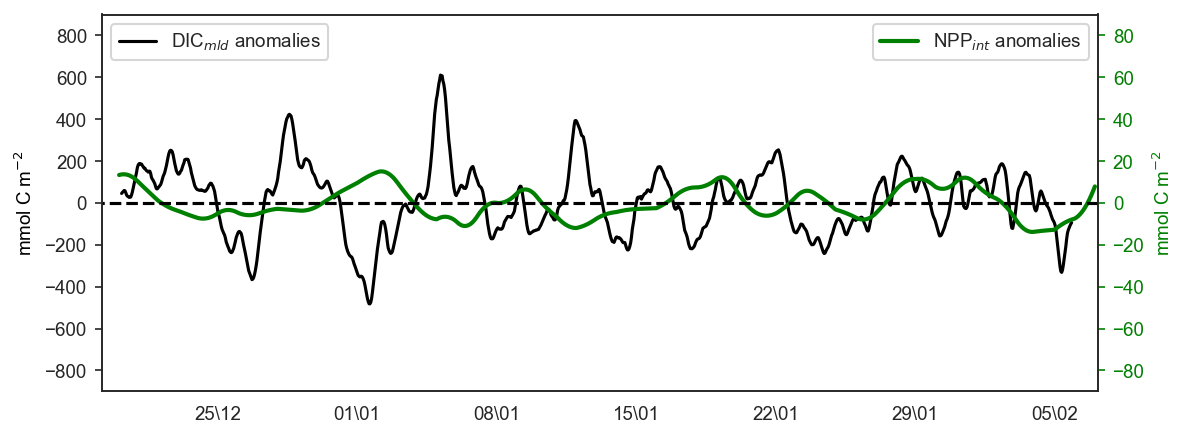

In [91]:
plt.figure(figsize=(8,3))
ax=subplot(111)
anoms_dic = (WG.DIC-WG.DIC.rolling(10*24,center=True).mean())
#dic_mld= anoms_dic*mld_wg
data = {'time':pd.to_datetime(WG.Date.values),'dicmld': anoms_dic*mld_wg.mld003}
dic_anoms = pd.DataFrame(data)
dic_anoms  = dic_anoms.set_index('time')
#ax.plot(pd.to_datetime(WG.Date.values[99:-147]),dic_anoms.dicmld.rolling(24,center=True).mean()[99:-147],label='DIC$_{mld}$ anomalies',color='k')


ax.plot(pd.to_datetime(WG.Date.values[99:-147]),dic_anoms.dicmld.rolling(8,center=True).mean()[99:-147],label='DIC$_{mld}$ anomalies',color='k')
ax.set_xlim(pd.to_datetime(WG.Date[100]),pd.to_datetime(WG.Date[1300]))
plt.legend(loc=2)
plt.ylabel('mmol C m$^{-2}$',color='k')
plt.ylim(-900,900)
ax1=ax.twinx()
anoms_pp = (ppT_int.timeintPP-ppT_int.timeintPP.rolling(24*10,center=True).mean())/12
ax1.plot(anoms_pp,label='NPP$_{int}$ anomalies',color='green',lw=2)
ax1.set_ylim(-90,90)
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%m'))
plt.axhline(0,1,0,color='k',ls='--')
plt.ylabel('mmol C m$^{-2}$',color='g')
plt.legend()
ax1.xaxis.label.set_color('green')
ax1.tick_params(axis='y', colors='g')

ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_major_locator(weeks)


plt.tight_layout()
